In [12]:
import os
import cv2
import numpy as np
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt1
from sklearn.utils import shuffle
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import BatchNormalization
from keras.layers import Input, Lambda, Dense, Flatten, Activation, Dropout
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras import applications

In [13]:
train = list(os.walk('C://Users/Arun Sharma/Desktop/trashnet')) #gives the list of all directories and subdirectories

In [14]:
label_names = train[0][1]
dict_labels = dict(zip(label_names, list(range(len(label_names)))))
print(dict_labels)

{'cardboard': 0, 'glass': 1, 'metal': 2, 'paper': 3, 'plastic': 4, 'trash': 5}


In [15]:
def dataset(path): #put path till the highest directory level
    images = []
    labels = []
    for folder in tqdm(os.listdir(path)):
        value_of_label = dict_labels[folder] #dict_labels is the dictionary whose key:value pairs are classes:numbers representing them

        for file in (os.listdir(os.path.join(path, folder))):
            path_of_file = os.path.join(os.path.join(path, folder), file)

            image = cv2.imread(path_of_file)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, (150, 150))
            images.append(image)
            labels.append(value_of_label)

    images = np.array(images, dtype = 'float32')/255.0
    labels = np.array(labels)

    return images, labels


images, labels = dataset('C://Users/Arun Sharma/Desktop/trashnet')
images, labels = shuffle(images, labels)

100%|██████████| 6/6 [00:04<00:00,  1.43it/s]


In [16]:
images.shape

(2527, 150, 150, 3)

# Sample Images

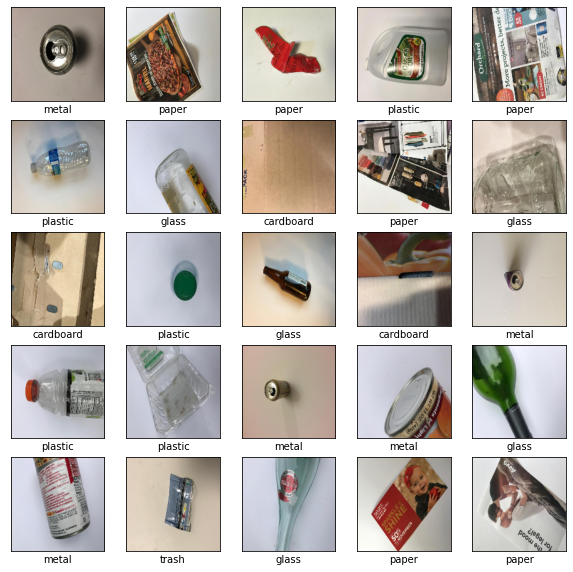

In [23]:
plt.figure(figsize = (10,10))
for _ in range(25):
    plt.subplot(5, 5, _+1)
    plt.yticks([])
    plt.xticks([])
    plt.grid(False)
    data = images[_]
    plt.xlabel(label_names[labels[_]])
    plt.imshow(data);

# Load images using ImageDatagenerator

In [24]:
image_size = (224, 224)
batch_size = 64
train_datagen = ImageDataGenerator(rescale = 1./255,
                            shear_range = 0.4,
                            zoom_range = 0.4,
                            horizontal_flip = True,
                            vertical_flip = True,
                            validation_split = 0.2)

In [25]:
train_ds = train_datagen.flow_from_directory('C://Users/Arun Sharma/Desktop/trashnet',
                                      target_size = image_size,
                                      batch_size = batch_size,
                                      class_mode = 'categorical',
                                      subset = 'training',
                                      color_mode="rgb",)

val_ds = train_datagen.flow_from_directory('C://Users/Arun Sharma/Desktop/trashnet',
                                      target_size = image_size,
                                      batch_size = batch_size,
                                      class_mode = 'categorical',
                                      subset = 'validation',
                                      color_mode="rgb")

Found 2024 images belonging to 6 classes.
Found 503 images belonging to 6 classes.


In [26]:
train_ds.class_indices

{'cardboard': 0, 'glass': 1, 'metal': 2, 'paper': 3, 'plastic': 4, 'trash': 5}

# some augmented images 

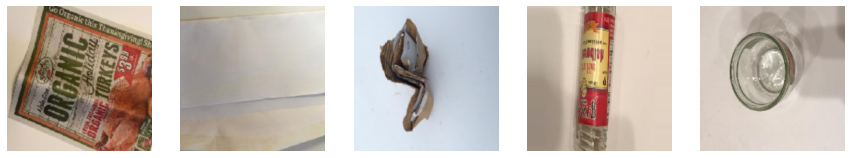

In [27]:
fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(15,15))

for i in range(5):
    image = next(train_ds)[0][0]
    image = np.squeeze(image)
    ax[i].imshow(image)
    ax[i].axis(False)

# Transfer learning

In [36]:
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
vgg_base = applications.vgg16.VGG16(weights = 'imagenet', include_top = False, input_shape = (224, 224, 3))
vgg_base.trainable = False

In [38]:
inputs = Input(shape=(224, 224, 3))

x = vgg_base(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(1024, activation = 'relu')(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(6, activation = 'sigmoid')(x)
vgg_model = Model(inputs, outputs)
vgg_model.summary

<bound method Model.summary of <keras.engine.functional.Functional object at 0x000001DA5D09F6D0>>

In [39]:
vgg_model.compile(
    optimizer=keras.optimizers.Adam(),
    loss= keras.losses.CategoricalCrossentropy(from_logits = True),
    metrics= [keras.metrics.CategoricalAccuracy()],
)

In [40]:
epochs = 25
vgg_model.fit(train_ds, epochs=epochs, validation_data=val_ds)

Epoch 1/25


C:\Users\Arun Sharma\anaconda3\lib\site-packages\tensorflow\python\util\dispatch.py:1082: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


32/32 [==============================] - 136s 4s/step - loss: 1.5403 - categorical_accuracy: 0.3696 - val_loss: 1.3176 - val_categorical_accuracy: 0.4652
Epoch 2/25
32/32 [==============================] - 137s 4s/step - loss: 1.2529 - categorical_accuracy: 0.5089 - val_loss: 1.1902 - val_categorical_accuracy: 0.5328
Epoch 3/25
32/32 [==============================] - 142s 4s/step - loss: 1.1283 - categorical_accuracy: 0.5613 - val_loss: 1.1229 - val_categorical_accuracy: 0.5646
Epoch 4/25
32/32 [==============================] - 143s 4s/step - loss: 1.0340 - categorical_accuracy: 0.6126 - val_loss: 1.1023 - val_categorical_accuracy: 0.5606
Epoch 5/25
32/32 [==============================] - 141s 4s/step - loss: 0.9771 - categorical_accuracy: 0.6443 - val_loss: 1.0452 - val_categorical_accuracy: 0.5905
Epoch 6/25
32/32 [==============================] - 143s 4s/step - loss: 0.9439 - categorical_accuracy: 0.6482 - val_loss: 1.0174 - val_categorical_accuracy: 0.5885
Epoch 7/25
32/32 [===

In [42]:
vgg_model.save('vgg.hdf5') #this saves the model with the weights

# Testing model on our image

In [48]:
def predictor(img, model):
    image = cv2.imread(img)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (224, 224))
    image = np.array(image, dtype = 'float32')/255.0
    plt.imshow(image)
    image = image.reshape(1, 224,224,3)
    
    label_names = train_ds.class_indices
    dict_class = dict(zip(list(range(len(label_names))), label_names))
    clas = model.predict(image).argmax()
    name = dict_class[clas]
    print('The given image is of \nClass: {0} \nObject: {1}'.format(clas, name))

The given image is of 
Class: 5 
Object: trash


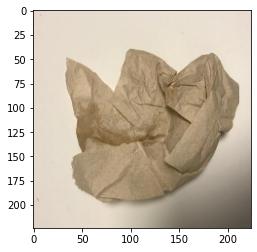

In [49]:
predictor('C://Users/Arun Sharma/Desktop/trashnet/trash/trash8.jpg', vgg_model) #example image